<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica 13

Modelos no-lineales y modelos físicos

In [2]:
import io, os
import numpy as np
import scipy.stats as st
import scipy.special as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pymc
import pymc as pm
import arviz as az
import pandas as pd
import aesara.tensor as at

In [3]:
!pip install openseespy
import openseespy.opensees as op

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 8.9 MB/s 
     |████████████████████████████████| 12.8 MB 49.7 MB/s 


## Datasets

### Dataset 1: Tensión en cables

Fuente: LABDIN-FIUBA

In [4]:
# Abrimos un archivo local
from google.colab import files
uploaded = files.upload()

Saving Cables.csv to Cables.csv


In [5]:
# Se crea un DataFrame
df_cables = pd.read_csv(io.BytesIO(uploaded['Cables.csv']))
df_cables.head()

,fn_Hz,n,N_Cable,Puente,long_m,masa_p_long_kg_m
0,5.027848,1,1,C,9.821,3.6
1,10.131991,2,1,C,9.821,3.6
2,15.548943,3,1,C,9.821,3.6
3,21.377890,4,1,C,9.821,3.6
4,27.748531,5,1,C,9.821,3.6


### Dataset 2: Ensayos de vibraciones forzadas

Fuente: LABDIN-FIUBA



In [6]:
# Abrimos un archivo local
from google.colab import files
uploaded = files.upload()

Saving vibracion_forzada.csv to vibracion_forzada.csv


In [7]:
# Se crea un DataFrame
df_vibracion = pd.read_csv(io.BytesIO(uploaded['vibracion_forzada.csv']))
df_vibracion['TR'] = df_vibracion['Aceleracion maxima'] / df_vibracion['Aceleracion mesa']
df_vibracion.head()

,Frecuencia (Hz),Aceleracion mesa,Aceleracion maxima,TR
0,1.22,0.042213,0.19670,4.659702
1,1.24,0.044881,0.22513,5.016154
2,1.26,0.045054,0.25912,5.751321
3,1.28,0.046586,0.29825,6.402138
4,1.30,0.046185,0.32463,7.028905


## Ejemplo 0: Modelo sintético

Comparación de ajuste de distintos modelos (lineal polinómico, no-paramétrico y no-lineal)

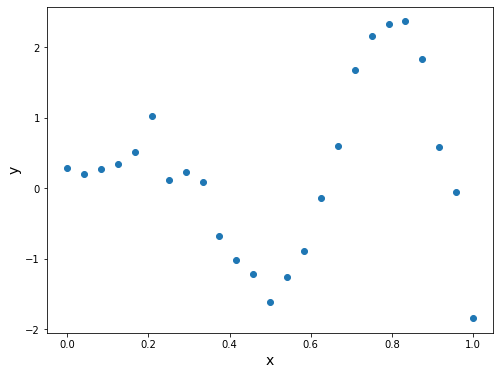

In [9]:
# Función real
f = lambda x: 3*x*np.sin(10*x)
# Observaciones
np.random.seed(62345)
N = 25
x = np.linspace( 0, 1, N )
eps = np.random.normal( size=N, scale=0.2 ) # Ruido
y = f( x ) + eps

# Ploteo
fig, ax = plt.subplots( figsize=(8,6) )
ax.plot( x, y, 'C0o' )
ax.set_xlabel('x', fontsize=14 )
ax.set_ylabel('y', fontsize=14 );

### regresión lineal con polinomios

In [10]:
degree = 5 # grado del polinomio
x0 = (x-x.mean())/x.std() # estandarización de x
y0 = (y-y.mean())/y.std() # estandarización d y
with pm.Model() as model_01:

    # Data container
    X = pm.MutableData('X',x0)
    B = pm.math.stack([X**(i+1) for i in range(degree)])

    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=2, shape=degree )
    sigma = pm.Exponential("sigma", 1)

    # Verosimilitud
    mu = pm.Deterministic( 'mu', alpha + pm.math.dot( B.T, beta ) )
    y_ = pm.Normal( "y_", mu=mu, sigma=sigma, observed=y0 )

    # Valor medio de y sin estandarizar
    mu0 = pm.Deterministic('mu0', mu*y.std()+y.mean())
    
    # Posterior
    trace_01 = pm.sample( 3000, tune=1000, cores=2, target_accept=0.9 )

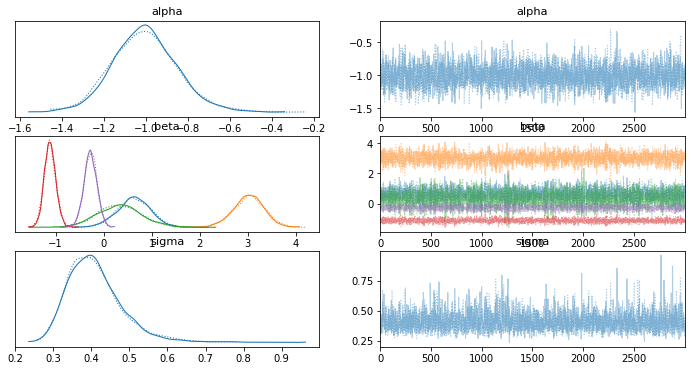

In [11]:
az.plot_trace( trace_01, var_names=['~mu','~mu0'] );

In [12]:
# Predicción en xtest para plotear mejor
xtest = np.arange(-2,3,0.02)
with model_01:
    pm.set_data({'X':xtest})
    ppc_01 = pm.sample_posterior_predictive( trace_01, var_names=['mu0'] )

Text(0, 0.5, 'y')

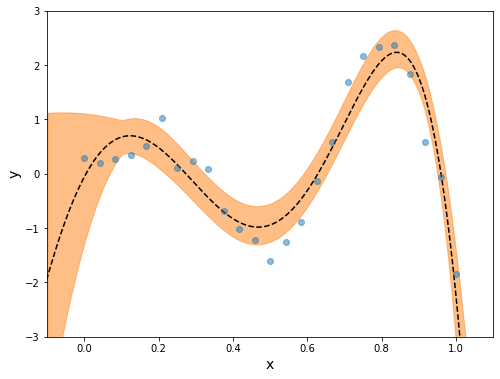

In [13]:
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media
ax.plot( xtest*x.std()+x.mean(), ppc_01.posterior_predictive['mu0'].mean(['chain','draw']),'k--')

# HDI de mu
az.plot_hdi( xtest*x.std()+x.mean(), ppc_01.posterior_predictive['mu0'], color='C1', ax=ax )

# Observaciones
ax.plot( x, y, 'C0o', alpha=.5 )

# Formateo
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-3,3])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)

### regresión con GPs

In [ ]:
with pm.Model() as model_02:

    # Prioris
    tau = pm.LogNormal("tau", mu=0, sigma=1)
    l = pm.LogNormal("l", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)

    cov = tau * pm.gp.cov.ExpQuad( 1, l )
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x.reshape(-1,1))

    # Verosimilitud
    y_ = pm.Normal( "y", mu=f, sigma=sigma, observed=y )

    # Simulación posterior de f
    trace_02 = pm.sample( 1000, tune=2000, cores=2, target_accept=0.9 )

In [ ]:
az.plot_trace( trace_02, var_names=['tau','l','sigma'] );

In [ ]:
# Predicciones para xtest solo para plotear mejor
xtest = np.arange(-0.1,2.1,0.02)
with model_02:
    f_test = gp.conditional("f_test", xtest.reshape(-1,1), jitter=1e-4)
    ppc_02 = pm.sample_posterior_predictive( trace_02.posterior,
                                             var_names=["f_test"])

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media
ax.plot( xtest, ppc_02.posterior_predictive['f_test'].mean(['chain','draw']),'k--')

# HDI de mu
az.plot_hdi( xtest, ppc_02.posterior_predictive['f_test'], color='C1', ax=ax )

# Observaciones
ax.plot( x, y, 'C0o', alpha=.5 )

# Formateo
ax.set_xlim([-0.1,1.1])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)

### regresión no-lineal

In [ ]:
with pm.Model() as model_03:

    # Data container
    X = pm.MutableData('X',x)

    # Prioris
    alpha = pm.LogNormal("alpha", mu=0, sigma=3)
    beta = pm.LogNormal("beta", mu=0, sigma=3)
    sigma = pm.Exponential("sigma", lam=1)

    # Valor medio
    mu = pm.Deterministic( "mu", alpha * X * pm.math.sin( beta*X ) )

    # Verosimilitud
    y_ = pm.Normal("y_", mu=mu, sigma=sigma, observed=y )

    # Simular distribución posterior
    trace_03 = pm.sample( 3000, tune=3000, cores=2, target_accept=0.9 )

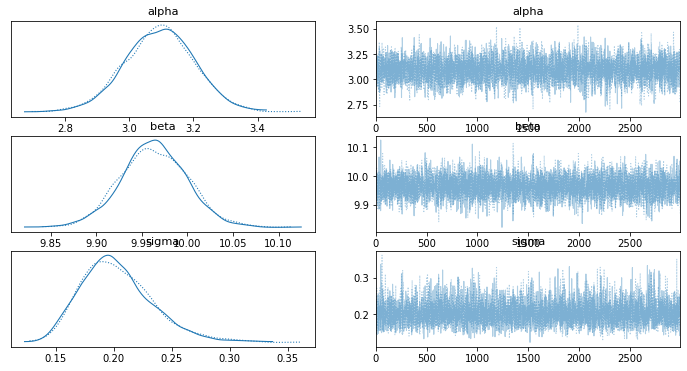

In [ ]:
az.plot_trace( trace_03, var_names=['~mu']);

In [ ]:
# Predicción en xtest para plotear mejor
xtest = np.arange(-0.1,2.1,0.02)
with model_03:
    pm.set_data({'X':xtest})
    ppc_03 = pm.sample_posterior_predictive( trace_03, var_names=['mu','y_'] )

Text(0, 0.5, 'y')

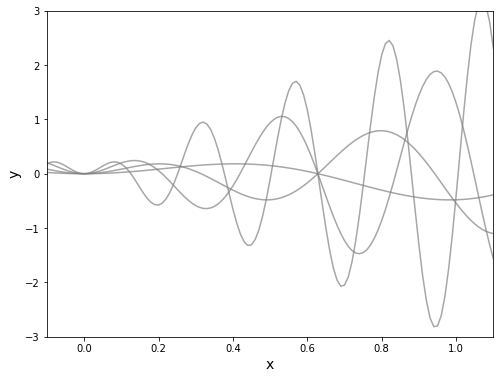

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

alphas = [0.5,1,2,3]
betas = [5,10,15,25]
xx = np.arange(-0.1,1.1,0.01)
for i in range(4):
    ax.plot( xx, alphas[i]*xx*np.sin(betas[i]*xx), color='gray', alpha=0.7 )


# Línea media
# ax.plot( xtest, ppc_03.posterior_predictive['mu'].mean(['chain','draw']),'k--')

# HDI de mu
# az.plot_hdi( xtest, ppc_03.posterior_predictive['mu'], color='C1', ax=ax, smooth=False )

# Observaciones
# ax.plot( x, y, 'C0o', alpha=.5 )

# Formateo
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-3,3])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)

### Comparación de modelos

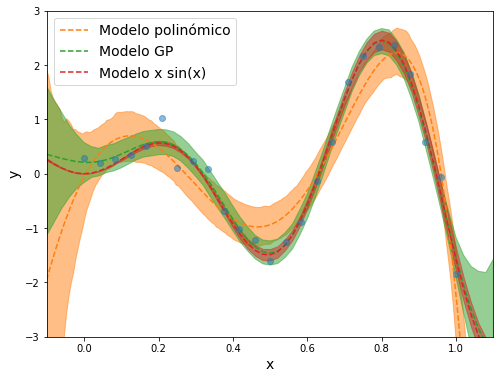

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Modelo 1
xtest = np.arange(-2,2,0.02)
ax.plot( xtest*x.std()+x.mean(), ppc_01.posterior_predictive['mu0'].mean(['chain','draw']),
         'C1--', label='Modelo polinómico' )
az.plot_hdi( xtest*x.std()+x.mean(), ppc_01.posterior_predictive['mu0'],
             color='C1', ax=ax, smooth=False )
# Modelo 2
xtest = np.arange(-0.1,1.1,0.02)
ax.plot( xtest, ppc_02.posterior_predictive['f_test'].mean(['chain','draw']),
         'C2--', label='Modelo GP')
az.plot_hdi( xtest, ppc_02.posterior_predictive['f_test'], color='C2', ax=ax,
             smooth=False )
# Modelo 3
xtest = np.arange(-0.1,1.1,0.02)
ax.plot( xtest, ppc_03.posterior_predictive['mu'].mean(['chain','draw']),'C3--',
         label='Modelo x sin(x)')
az.plot_hdi( xtest, ppc_03.posterior_predictive['mu'], color='C3', ax=ax,
             smooth=False )

# Observaciones
ax.plot( x, y, 'C0o', alpha=.5 )

# Formateo
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-3,3])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.legend( fontsize=14 );

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distrib

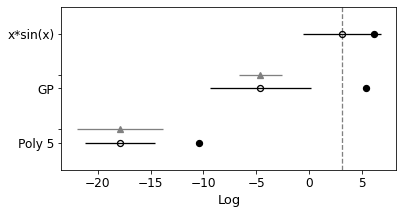

In [ ]:
models_list = {'Poly 5':trace_01,'GP':trace_02,'x*sin(x)':trace_03}
models_comp = az.compare( models_list )
az.plot_compare( models_comp )

In [ ]:
models_comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
x*sin(x),0,2.870527,3.270722,0.000000,0.933081,3.669779,0.000000,True,log
Poly 6,1,-1.462179,6.879385,4.332706,0.066919,2.888671,2.923071,True,log
GP,2,-3.938172,9.547485,6.808699,0.000000,4.499639,1.487471,True,log


## Ejemplo 1: Ensayo de vibraciones forzadas

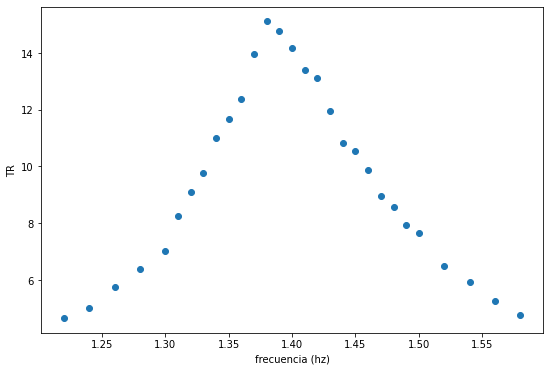

In [ ]:
x = df_vibracion['Frecuencia (Hz)'].to_numpy()
y = df_vibracion['TR'].to_numpy()

fig, ax = plt.subplots( figsize=(9,6) )

ax.plot( x, y, 'C0o' )

ax.set_xlabel('frecuencia (hz)')
ax.set_ylabel('TR');

In [ ]:
with pm.Model() as model_21:

    # Container
    X = pm.MutableData("X",x)

    # Prioris
    omegan = pm.LogNormal("omegan", mu=0, sigma=1)
    seda = pm.Uniform("seda", lower=0, upper=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # Valor medio
    mu = pm.Deterministic( "mu", pm.math.sqrt( (1 + (2*seda*2*np.pi*X/omegan)**2 )/ \
                                              ((1-(2*np.pi*X)**2/omegan**2)**2 +    \
                                               (2*seda*(2*np.pi*X)**2/omegan**2)**2) ) )

    # Verosimilitud
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y )

    # Simular distribución posterior
    trace_21 = pm.sample( 3000, tune=2000, cores=2 )

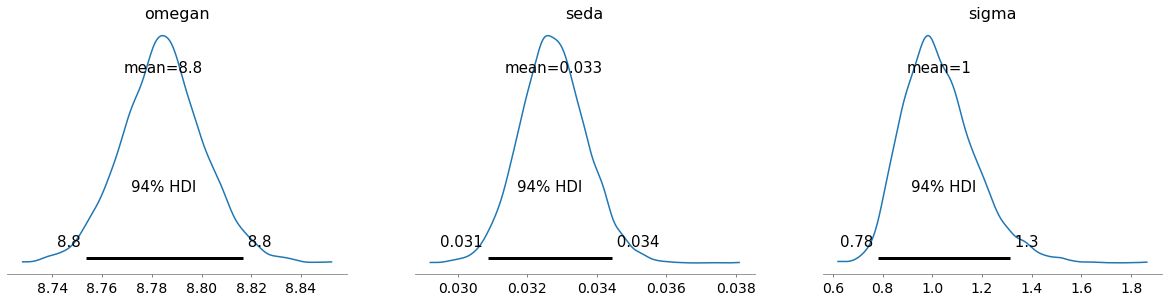

In [ ]:
az.plot_posterior( trace_21, var_names=['~mu']);

In [ ]:
xtest = np.arange(0.8,2,0.01)
with model_21:
    pm.set_data({"X":xtest})
    ppc_21 = pm.sample_posterior_predictive( trace_21, var_names=['mu'] )

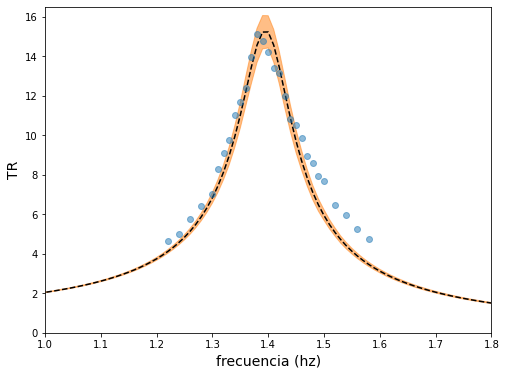

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media
ix = np.argsort(x)
ax.plot( xtest, ppc_21.posterior_predictive['mu'].mean(['chain','draw']),'k--')

# HDI de mu
az.plot_hdi( xtest, ppc_21.posterior_predictive['mu'], color='C1', ax=ax, smooth=False )

# Observaciones
ax.plot( x, y, 'C0o', alpha=.5 )

# Formateo
ax.set_xlim([1,1.8])
ax.set_ylim([0,16.5])
ax.set_xlabel( 'frecuencia (hz)', fontsize=14 )
ax.set_ylabel( 'TR', fontsize=14 );

### Ajuste con GPs

In [ ]:
with pm.Model() as model_22:

    # Prioris
    tau = pm.LogNormal("tau", mu=0, sigma=1)
    l = pm.LogNormal("l", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)

    cov = tau * pm.gp.cov.ExpQuad( 1, l )
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x.reshape(-1,1))

    # Verosimilitud
    y_ = pm.Normal( "y", mu=f, sigma=sigma, observed=y )

    # Simulación posterior de f
    trace_22 = pm.sample( 1000, tune=2000, cores=2, target_accept=0.9 )

ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# Predicciones para xtest solo para plotear mejor
xtest = np.arange(0.5,2.6,0.01)
with model_22:
    f_test = gp.conditional("f_test3", xtest.reshape(-1,1), jitter=1e-3)
    ppc_22 = pm.sample_posterior_predictive( trace_22.posterior,
                                             var_names=["f_test3"] )

Text(0, 0.5, 'TR')

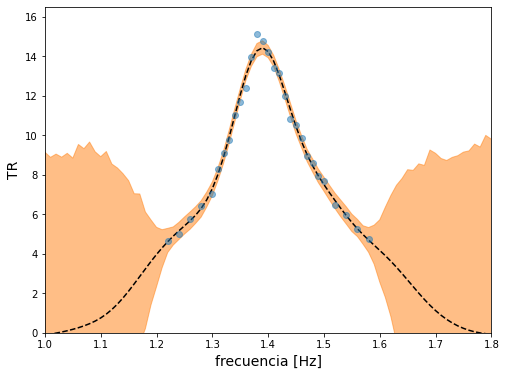

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media
ax.plot( xtest, ppc_22.posterior_predictive['f_test3'].mean(['chain','draw']),'k--')

# HDI de mu
az.plot_hdi( xtest, ppc_22.posterior_predictive['f_test3'], color='C1', ax=ax, smooth=False )

# Observaciones
ax.plot( x, y, 'C0o', alpha=.5 )

# Formateo
ax.set_xlim([1,1.8])
ax.set_ylim([0,16.5])
ax.set_xlabel('frecuencia [Hz]', fontsize=14)
ax.set_ylabel('TR', fontsize=14)

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


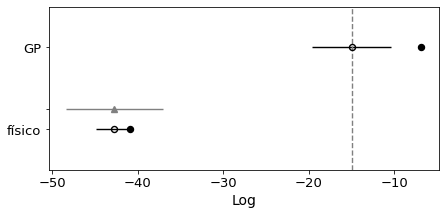

In [ ]:
models_list = {'físico':trace_21,'GP':trace_22}
models_comp = az.compare( models_list )
az.plot_compare( models_comp, figsize=(7,3) )

## Ejemplo 2: Modelo físico lineal (cables)

In [ ]:
# Creación de columnas nuevas para x e y
df_cables['x'] = ( df_cables['n'] * np.pi / df_cables['long_m'] ) ** 2
df_cables['y'] = 4*df_cables['long_m']**2 * df_cables['masa_p_long_kg_m'] * (df_cables['fn_Hz']/df_cables['n'])**2 /1000

x = df_cables['x'].to_numpy()
y = df_cables['y'].to_numpy()
n_cable = df_cables['N_Cable'].to_numpy()
estado = 1*(df_cables['Puente']=='A').to_numpy()

In [ ]:
with pm.Model() as model_01:

    # Prioris
    T = pm.Normal("T", mu=100, sigma=20, shape=(18,2) )
    EJ = pm.Normal("EJ", mu=100, sigma=50, shape=18 )
    sigma = pm.Exponential("sigma", lam=1)

    # Valor medio
    mu = pm.Deterministic( "mu", T[n_cable-1,estado] + EJ[n_cable-1] * x )

    # Verosimilitud
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y )

    # Simular distribuciones a priori
    prior_check_01 = pm.sample_prior_predictive( 1000 )

    # Simular distribución posterior
    trace_01 = pm.sample( 3000, tune=2000, cores=2 )

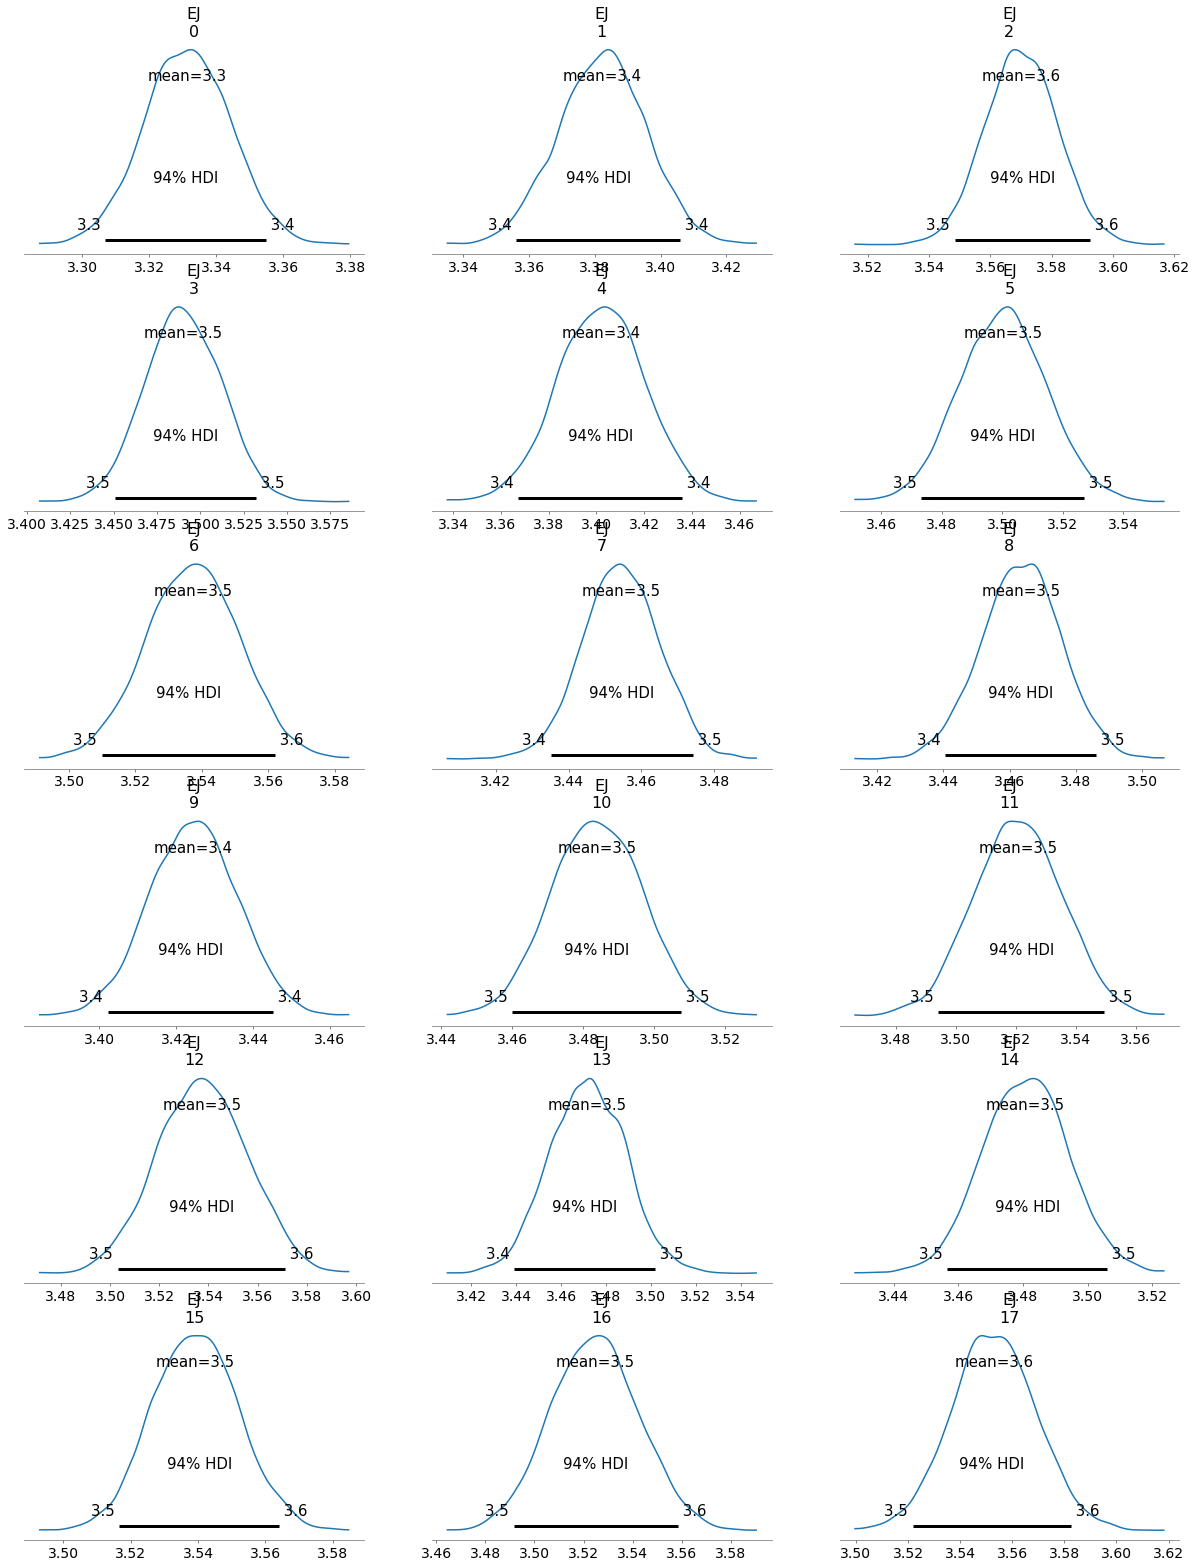

In [ ]:
az.plot_posterior( trace_01, var_names=['EJ'] );

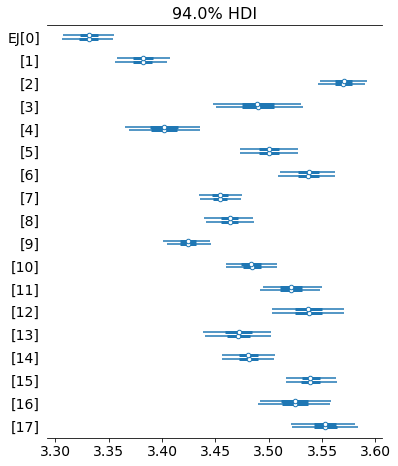

In [ ]:
az.plot_forest( trace_01, var_names=['EJ'] );

## Ejemplo 2: Regresión no-lineal sin función explícita (black-box)

In [ ]:
# Función externa (fuera de pymc)
def f_externa(beta, x):
    return beta[0] + beta[1] * x

In [ ]:
# Generación de dataset sintético
N = 10  # N de obs
sigma_true = 1.0  # ruido
x = np.linspace(0.0, 9.0, N)

# Modelo real
atrue = 3
btrue = 0.4
truemodel = f_externa([atrue, btrue], x)

# make data
rng = np.random.default_rng(716743)
data = sigma_true * rng.normal(size=N) + truemodel

fig, ax  = plt.subplots( figsize=(7,7) )
ax.plot( x, data, 'C0o' )
ax.set_xlabel('x', fontsize=14 )
ax.set_ylabel('y', fontsize=14 );

NameError: ignored

In [ ]:
# definir unf función (Op) en aesara para la función
class custom_f(at.Op):

    """
    Especificar qué tipo de objetas serán pasados y devueltos por la función (Op)
    cuando es llamada. En este caso, el input de la función es un vector de 2
    valores (los parámetros a calibrar del modelo) y el output de la función es
    también un vector (la función para todos los valores observados de x)
    """

    itypes = [at.dvector]  # expects a vector of parameter values when called
    otypes = [at.dvector]  # outputs a vector value

    def __init__(self, cfunc, x):
        self.cfunc = cfunc # La función externa
        self.x = x # Los parámetros observables

    def perform(self, node, inputs, outputs):
        # Este método es usado cada vez que se llama a la función

        (theta,) = inputs # this will contain my variables

        # Llamar a la función externa
        f = self.cfunc(theta, self.x)

        outputs[0][0] = f  # output the function values

In [ ]:
# Función externa
def f_externa(beta, x):
    return beta[0] + beta[1] * x

# Crear Op de aesara
f_externa_op = custom_f(f_externa, x)

with pm.Model() as model_31:

    # Prioris
    beta0 = pm.Normal("beta0", mu=0, sigma=3)
    beta1 = pm.Normal("beta1", mu=0, sigma=3)
    sigma = pm.Exponential("sigma", lam=1)

    # Función media
    beta = pm.math.stack([beta0, beta1])
    mu = pm.Deterministic( "mu", f_externa_op(beta) )

    # Verosimilitud
    y_ = pm.Normal("y_", mu=mu, sigma=sigma, observed=data)

    # Simulaciones posteriores
    trace_31 = pm.sample( 3000, tune=2000, cores=2 )

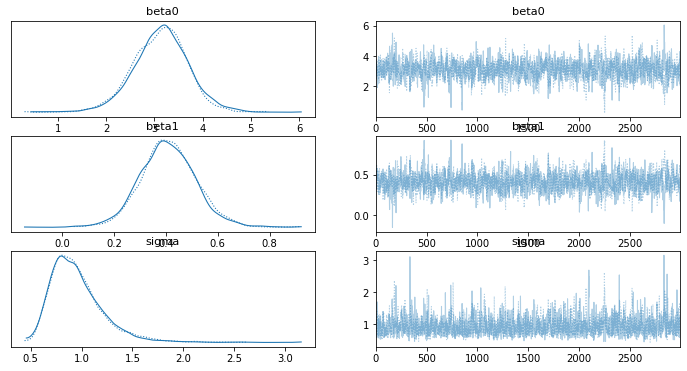

In [ ]:
# plot the traces
az.plot_trace( trace_31, var_names=[ "~mu"]);

### Regresión lineal simple para comparación

In [ ]:
with pm.Model() as model_32:

    # Prioris
    beta0 = pm.Normal("beta0", mu=0, sigma=3)
    beta1 = pm.Normal("beta1", mu=0, sigma=3)
    sigma = pm.Exponential("sigma", lam=1)

    # Función media
    mu = pm.Deterministic( "mu", beta0 + beta1 * x )

    # Verosimilitud
    y_ = pm.Normal("y_", mu=mu, sigma=sigma, observed=data)

    # Simulaciones posteriores
    trace_32 = pm.sample( 3000, tune=2000, cores=2 )

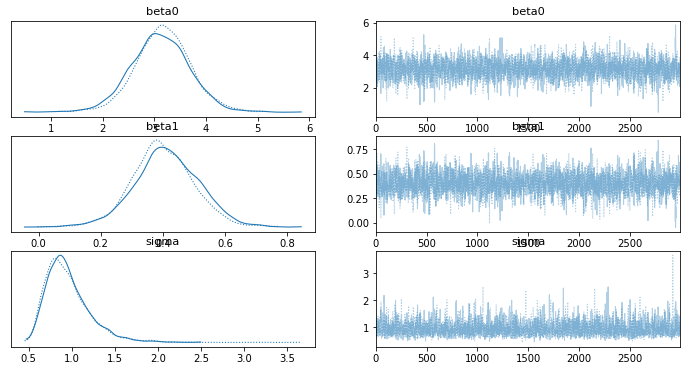

In [ ]:
# plot the traces
az.plot_trace( trace_32, var_names=[ "~mu"]);

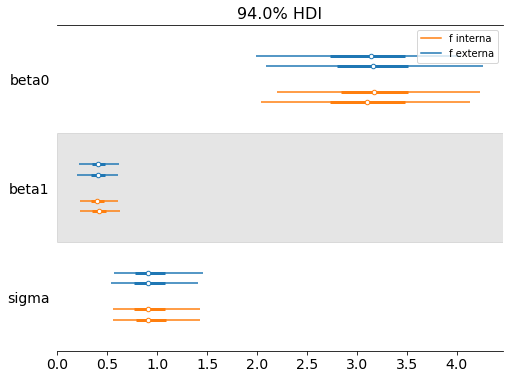

In [ ]:
az.plot_forest( [trace_31,trace_32], model_names=['f externa','f interna'], var_names=['~mu'], figsize=(8,6) );

## Ejemplo 4: Modelo físico implícito (estructura no-lineal)

In [ ]:
def nonlinear_truss( A, E, alpha, sY, Py, Pxmax, px ):
    """
    A: área de la sección
    E: módulo de elasticidad longitudinal
    alpha: Factor del módulo de endurecimiento cinemático Hcin=alpha/(1-alpha)*E
    sY: tensión de fluencia
    Py: componente vertical de la carga (constante)
    Pxmax: componente lateral de la carga máxima
    px: valores intermedios de la carga Px para la cual devolver los desplazamientos
    """

    # ------------------------------
    # Start of model generation
    # -----------------------------

    # set modelbuilder
    op.wipe()
    op.model('basic', '-ndm', 2, '-ndf', 2)

    # variables
    udisp = 2.5
    Nsteps = 1000

    # create nodes
    op.node(1, 0.0, 0.0)
    op.node(2, 72.0, 0.0)
    op.node(3, 168.0, 0.0)
    op.node(4, 48.0, 144.0)

    # set boundary condition
    op.fix(1, 1, 1)
    op.fix(2, 1, 1)
    op.fix(3, 1, 1)

    # define materials
    op.uniaxialMaterial("Hardening", 1, E, sY, 0.0, alpha/(1-alpha)*E)

    # define elements
    op.element("Truss",1,1,4,A,1)
    op.element("Truss",2,2,4,A,1)
    op.element("Truss",3,3,4,A,1)

    # create TimeSeries
    op.timeSeries("Linear", 1)

    # create a plain load pattern
    op.pattern("Plain", 1, 1)

    # Create the nodal load
    op.load(4, Pxmax, Py)

    # ------------------------------
    # Start of analysis generation
    # ------------------------------

    # create SOE
    op.system("ProfileSPD")
    # create DOF number
    op.numberer("Plain")
    # create constraint handler
    op.constraints("Plain")
    # create integrator
    op.integrator("LoadControl", 1.0/Nsteps)
    # create algorithm
    op.algorithm("Newton")
    # create test
    op.test('NormUnbalance',1e-8, 10)
    # create analysis object
    op.analysis("Static")

    # ------------------------------
    # Finally perform the analysis
    # ------------------------------

    # perform the analysis
    data = np.zeros((Nsteps+1,2))
    for j in range(Nsteps):
        op.analyze(1)
        data[j+1,0] = op.nodeDisp(4,1)
        data[j+1,1] = op.getLoadFactor(1)*Pxmax

    # Find data for ps
    data_out = np.zeros([px.size,2])
    for i in range(px.size):
        ix = np.where(data[:,1]<=px[i])[0][-1]
        data_out[i,:] = data[ix,:]

    return data, data_out[:,0]

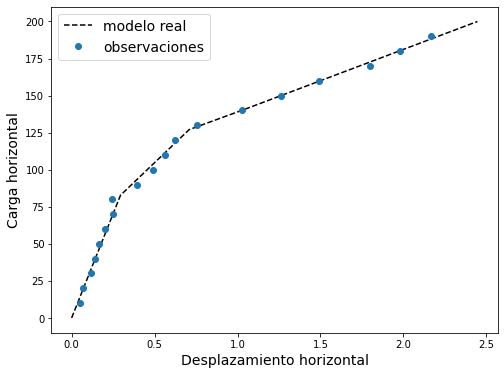

In [ ]:
np.random.seed(523)

# Creación de observaciones a partir de un modelo "real" más ruido
A = 4
E_true = 29000
Pmax = 200
Py = 300
sY = 36
alpha_true = 0.15
x = np.arange( 10, Pmax, 10 )
data, disp_out = nonlinear_truss( A, E_true, alpha_true, sY, Py, Pmax, x )
y = disp_out + st.norm.rvs( size=x.size, scale=0.02 )

# Ploteo de obsrevaciones sintéticas
fig, ax = plt.subplots( figsize=(8,6) )
ax.plot(data[:,0], data[:,1],'k--', label='modelo real')
ax.plot( y, x, 'C0o', label='observaciones' )
ax.set_xlabel('Desplazamiento horizontal', fontsize=14)
ax.set_ylabel('Carga horizontal', fontsize=14)
ax.legend( fontsize=14 );

In [ ]:
# Función externa
def f_externa(beta, x):
    A = 4
    sY = 36
    Pmax = 200
    Py = 300
    E, alpha = beta # Parámetros a calibrar
    _, disp_out = nonlinear_truss( A, E, alpha, sY, Py, Pmax, x )
    return disp_out

# Crear Op de aesara
f_externa_op = custom_f(f_externa, x)

Text(0, 0.5, 'Carga horizontal')

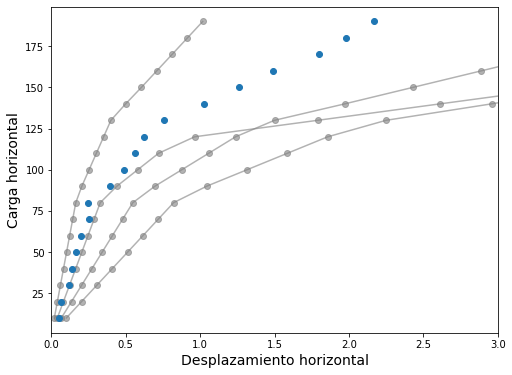

In [ ]:
# Algunas simulaciones para distintos valores de los parámetros
xi = np.arange( 10, Pmax, 10 ) # X observados

E_trues = [10000, 15000, 25000, 50000]
alphas = [0.15, 0.15, 0.05, 0.2]

# Ploteo
fig, ax = plt.subplots( figsize=(8,6) )

for i in range(4):
    yi = f_externa( (E_trues[i],alphas[i]), x )
    ax.plot( yi, xi, marker='o', linestyle='-',color='gray',alpha=.6)

ax.plot( y, x, 'C0o' )
ax.set_xlim([0,3])
ax.set_xlabel('Desplazamiento horizontal', fontsize=14)
ax.set_ylabel('Carga horizontal', fontsize=14)

In [ ]:
with pm.Model() as model_41:

    # Prioris
    E = pm.Normal("E", mu=20000, sigma=5000)
    alpha = pm.Uniform("alpha", lower=0.01, upper=0.6)
    sY = pm.Uniform("sY", lower=20, upper=50)
    A = pm.Uniform("A", lower=1, upper=10)
    sigma = pm.Exponential("sigma", lam=1)

    # Función media
    beta = pm.math.stack([E, alpha, sY, A])
    mu = pm.Deterministic( "mu", f_externa_op(beta) )

    # Verosimilitud
    y_ = pm.Normal("y_", mu=mu, sigma=sigma, observed=y)

    # Simulaciones posteriores
    trace_41 = pm.sample( 3000, tune=2000, cores=2 )

In [ ]:
az.plot_posterior( trace_41, var_names=['~mu'], ref_val=[E_true,alpha_true,0.02] );

Text(0, 0.5, 'Carga horizontal')

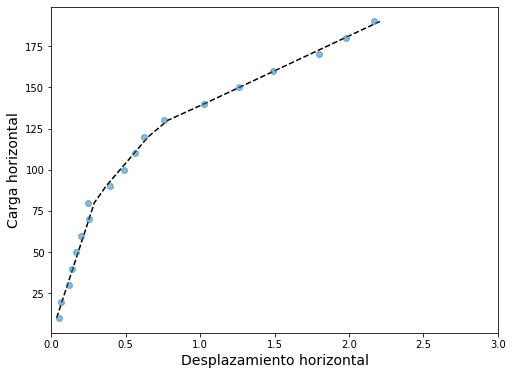

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media
ix = np.argsort(x)
ax.plot( trace_41.posterior['mu'].mean(['chain','draw'])[ix], x[ix], 'k--')

# HDI de mu
# az.plot_hdi( x, trace_41.posterior['mu'], color='C1', ax=ax )

# Observaciones
ax.plot( y, x, 'C0o', alpha=.5 )

# Formateo
ax.set_xlim([0,3])
ax.set_xlabel('Desplazamiento horizontal', fontsize=14)
ax.set_ylabel('Carga horizontal', fontsize=14)

## Ejemplo 5: Modelos surrogados 1D

In [ ]:
def SEcov( x1, x2, t ):
    """
    Isotropic squared exponential kernel
    k(x,x') = t[0]^2*exp(-1/2/t[1]^2 |x1-x2|^2)

    Args:
        x1: Array of m points (m x d).
        x2: Array of n points (n x d).
        theta: Kernel parameters
            theta[1]: amplitude
            theta[2]: range

    Returns:
        (m x n) matrix
    """
    r2 = np.sum(x1 ** 2, 1).reshape(-1, 1) + np.sum(x2 ** 2, 1) - 2 * np.dot(x1, x2.T)
    return t[0] ** 2 * np.exp(-1/2 / t[1] ** 2 * r2)

def gp_regression( xtrain, ytrain, xtest, theta, sn, cov_func ):

    # Matrices de covarianza
    K = cov_func( xtrain, xtrain, theta ) + sn**2 * np.eye( xtrain.size )
    Kd = cov_func( xtest, xtrain, theta )
    Kdd = cov_func( xtest, xtest, theta )

    # Parámetros de la distribución posterior de f
    f_mean = Kd.dot( np.linalg.solve( K, ytrain ) )
    f_cov = Kdd - Kd.dot( np.linalg.solve( K, Kd.T ) )

    return f_mean, f_cov

Text(0, 0.5, 'y')

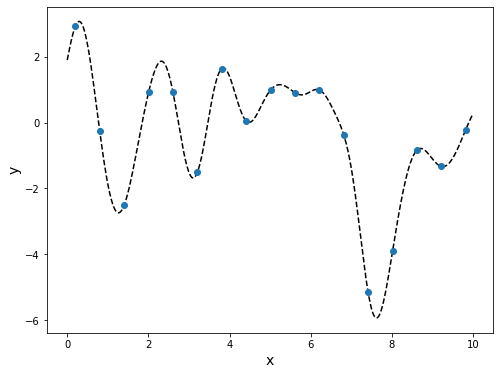

In [ ]:
np.random.seed(1234)

n = 500  # The number of data points
x = np.linspace(0, 10, n) # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = 0.5
tau_true = 2
cov_func = tau_true**2 * pm.gp.cov.ExpQuad(1, l_true)

# The latent function values are one sample from a multivariate normal
y = st.multivariate_normal.rvs( size=1, mean=np.zeros( x.shape[0] ),
                                     cov=cov_func(x[:, None]).eval() )

# Sampleo de puntos
ix = np.arange(10,n,30)
# ix = np.hstack([ix,150])
x0 = x[ix]
y0 = y[ix]

# Ploteo
fig, ax = plt.subplots( figsize=(8,6) )

# xplot = np.arange(0,2.6,0.05)
ax.plot( x,y,'k--' )
ax.plot( x0, y0, 'C0o' )

ax.set_xlabel( 'x', fontsize=14 )
ax.set_ylabel( 'y', fontsize=14 )

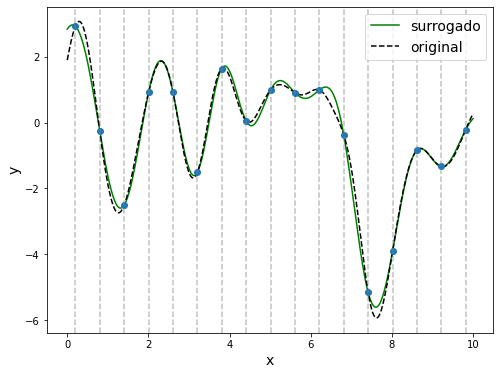

In [ ]:
# Regresión GP para un subconjunto de las observaciones
theta = [2,0.5]
sn = 0.01
f_mean, f_cov = gp_regression( x0.reshape(-1,1), y0,
                               x.reshape(-1,1), theta, sn,
                               SEcov )
# Simulaciones de f
rf = np.random.multivariate_normal( mean=f_mean, cov=f_cov, size=1000 )

# Intervalos de confianza
f_mean = rf.mean(axis=0)
fi_qi = np.quantile( rf, [0.05,0.95], axis=0 )

# Ploteo
fig, ax = plt.subplots( figsize=(8,6))

ax.plot( x, f_mean, 'g-', label='surrogado')
# ax.fill_between( x=x, y1=fi_qi[0], y2=fi_qi[1], color='C1', alpha=.5 )

xplot = np.arange(0,2.6,0.05)
ax.plot( x,y,'k--', label='original' )
ax.plot( x0, y0, 'C0o' )
# ax.plot( x0[-1],y0[-1], 'ro', markersize=10)

for i in ix:
    ax.axvline( x[i], color='gray', alpha=.5, linestyle='--' )

ax.set_xlabel( 'x', fontsize=14 )
ax.set_ylabel( 'y', fontsize=14 )
ax.legend( fontsize=14 );

In [ ]:
# Regresión con GP
with pm.Model() as model_61:

    # Prioris
    tau = pm.Exponential("tau", lam=1)
    l = pm.Exponential("l", lam=1)
    sigma = pm.Exponential("sigma", lam=1)

    cov = tau**2 * pm.gp.cov.ExpQuad( 1, l )
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior( "f", X=x0.reshape(-1,1) )

    # Verosimilitud
    y_ = pm.Normal( "y", mu=f, sigma=sigma, observed=y0 )

    # Simulación posterior de f
    trace_61 = pm.sample( 1000, tune=2000, cores=2 )

ValueError: ignored

In [ ]:
# Predicciones para xtest solo para plotear mejor
with model_61:
    f_pred = gp.conditional("f_test", xplot.reshape(-1,1), jitter=1e-4)
    ppc = pm.sample_posterior_predictive( trace_61.posterior, var_names=["f_test"])
    trace_61.extend(ppc)

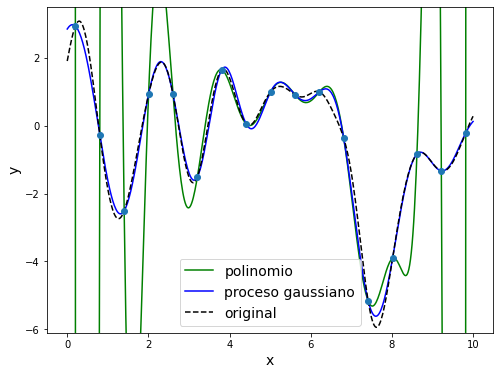

In [ ]:
# Ploteo
fig, ax = plt.subplots( figsize=(8,6))

# Polynomial interpolator
pol = np.polyfit(x0,y0,len(x0)-1)
ax.plot( x, np.polyval(pol,x) , 'g-', label='polinomio' )
ax.plot( x, f_mean, 'b-', label='proceso gaussiano')

# Data points
ax.plot( x,y,'k--', label='original' )
ax.plot( x0, y0, 'C0o' )

ax.set_ylim([-6.1,3.5])
ax.set_xlabel( 'x', fontsize=14 )
ax.set_ylabel( 'y', fontsize=14 )
ax.legend( fontsize=14 )